In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, PrecisionRecallDisplay, roc_curve, auc
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import SelectFromModel, RFE,RFECV
from sklearn.pipeline import Pipeline
import os
import other_ml_models
from comet_ml import Experiment
from comet_ml.integration.sklearn import log_model
from feature_engineering import FeatureEngineering
%matplotlib inline

In [12]:
pd.set_option('display.max_columns', 500)

In [4]:
experiment = Experiment(
  api_key=os.environ.get("COMET_API_KEY"),
  project_name="nhl-data-science",
  workspace="mahmoodhegazy"
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/mahmoodhegazy/nhl-data-science/541789fbaf424c19901b235e723cbd12



In [5]:
df = pd.read_csv("data/all_game_data_milesstone_2.csv")

In [3]:
df_train, df_test = FeatureEngineering("data/all_game_data_milesstone_2.csv").train_test_split()

In [4]:
df_train.season.value_counts()

season
20172018    81873
20182019    80478
20162017    74963
Name: count, dtype: int64

In [5]:
df_train.gameType.value_counts()

gameType
R    237314
Name: count, dtype: int64

## Visualizations

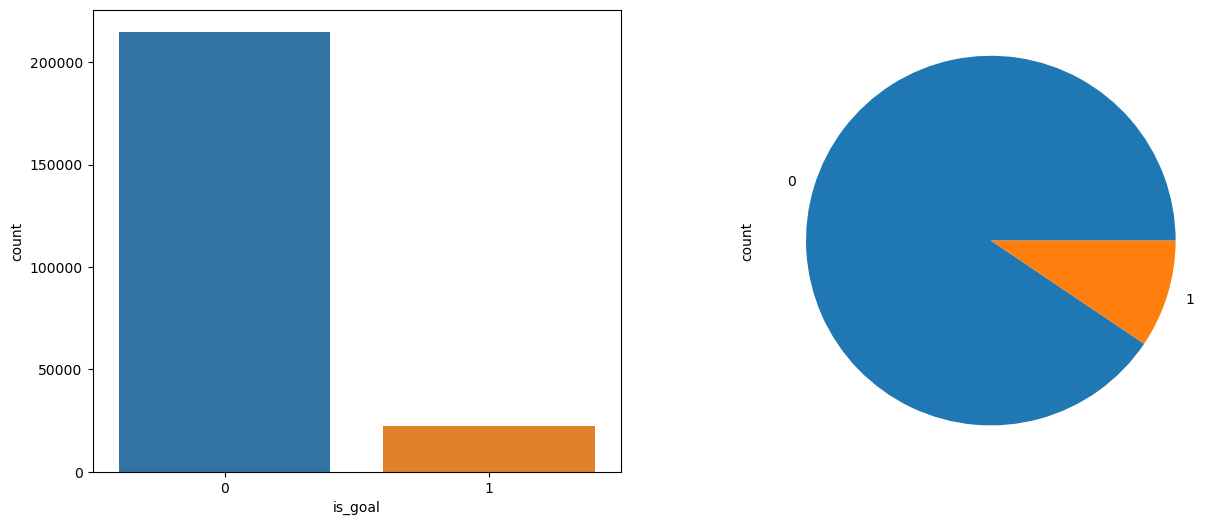

In [11]:
fig, ax=plt.subplots(1,2,figsize=(15,6))
_ = sns.countplot(x='is_goal', data=df_train, ax=ax[0])
_ = df_train['is_goal'].value_counts().plot.pie(ax=ax[1])

Check for nulls

<Axes: >

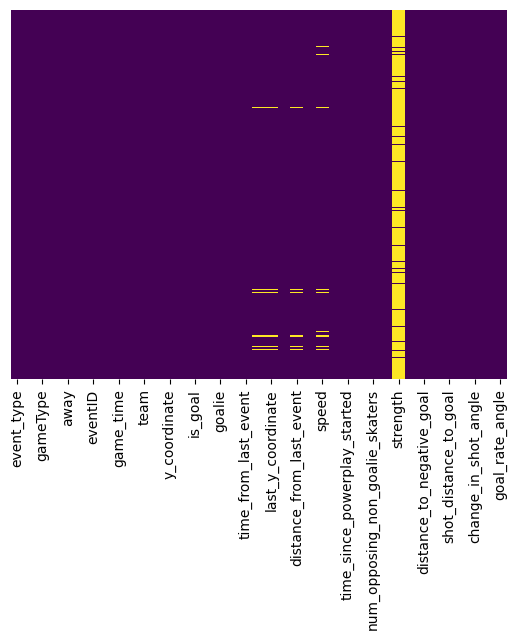

In [24]:
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Will add an imputer to the pipeline

Try to spot multicolinearity

<Axes: >

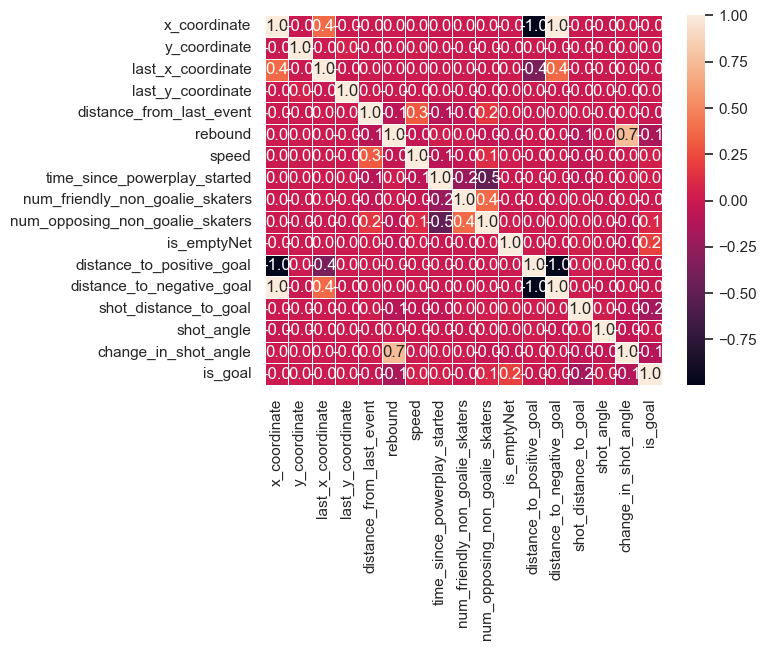

In [172]:
train_cols = ['x_coordinate', 'y_coordinate', 'last_x_coordinate',
       'last_y_coordinate', 'distance_from_last_event',
       'rebound', 'speed', 'time_since_powerplay_started',
       'num_friendly_non_goalie_skaters', 'num_opposing_non_goalie_skaters',
       'is_emptyNet', 'distance_to_positive_goal',
       'distance_to_negative_goal', 'shot_distance_to_goal',
       'shot_angle', 'change_in_shot_angle',"is_goal"]
# df_train[train_cols].corr()
sns.heatmap(df_train[train_cols].corr(), annot=True, linewidths=.5, fmt= '.1f')

Split into Train and Validation sets

In [6]:
train_cols = ['x_coordinate', 'y_coordinate', 'last_x_coordinate',
       'last_y_coordinate', 'distance_from_last_event','last_event',
       'rebound', 'speed', 'time_since_powerplay_started',
       'num_friendly_non_goalie_skaters', 'num_opposing_non_goalie_skaters',
       'is_emptyNet', 'shot_type', 'shot_distance_to_goal',
       'shot_angle', 'change_in_shot_angle']

X = df_train[train_cols]
y = df_train["is_goal"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

# Random Forest

## Create Pipeline

In [14]:
experiment_rf = Experiment(
  api_key=os.environ.get("COMET_API_KEY"),
  project_name="nhl-data-science",
  workspace="mahmoodhegazy"
)

[experiment_rf.log_dataset_hash(data_set) for data_set in [X_train, X_test, y_train, y_test]]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/mahmoodhegazy/nhl-data-science/34144ddb714e4845be497ce0e144f098



[None, None, None, None]

In [113]:
rf_clf= RandomForestClassifier(n_estimators='n_estimators',max_features='max_features',max_depth='max_depth',min_samples_split='min_samples_split',min_samples_leaf='min_samples_leaf', random_state=42)
recursive_cv_feature_selection = RFECV( min_features_to_select='min_features_to_select',estimator=LinearRegression())

rf_pipe = other_ml_models.create_pipeline(classifier=rf_clf,feature_selection=recursive_cv_feature_selection)

In [114]:
rf_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Numerical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x3d0ae84d0>),
                                                 ('Categorical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncod...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2f613cc50>)])),
                ('feature_select',
                 RFECV(estimator=LinearRegression(),
                       min_features_to_select='min_features_to_select')),
                ('classifier',
                 RandomForestClassifier(max_depth='max_depth',
                                        max_features='max_features',
                                        min_samples_leaf='min_samples_leaf',
                                        min_samples_split='min_samples_split',
                                        n_estimators='n_estimators',
                                        random_state=42))])

## Grid Search Hyperparamtuning

In [115]:
param_grid = {'classifier__n_estimators': [10, 20, 40, 80, 100],
                'classifier__max_features': ['log2', 'sqrt'],
                'classifier__max_depth': [20, 40, 60],
                'classifier__min_samples_split': [2, 4],
                'classifier__min_samples_leaf': [1, 2],
                'feature_select__min_features_to_select':[1,2,3]
}

# Fit a 3-fold GridSearchCV
rf_gs = GridSearchCV(rf_pipe, param_grid, cv=3, verbose=1, n_jobs=-1)
rf_gs.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters:")
print(rf_gs.best_params_)
print("Grid scores:")
means = rf_gs.cv_results_['mean_test_score']
stds = rf_gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, rf_gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


/Users/mahmoodhegazy/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters:
{'classifier__max_depth': 20, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 100, 'feature_select__min_features_to_select': 1}
Grid scores:
0.926 (+/-0.001) for {'classifier__max_depth': 20, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 10, 'feature_select__min_features_to_select': 1}
0.926 (+/-0.001) for {'classifier__max_depth': 20, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 10, 'feature_select__min_features_to_select': 2}
0.926 (+/-0.001) for {'classifier__max_depth': 20, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 10, 'feature_select__min_features_to_select': 3}
0.926 (+/-0.000) for {'classifier__max_depth': 20,

Train on best Hyperparams

In [116]:
rf_pipe_best = rf_gs.best_estimator_
rf_pipe_best.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Numerical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x3c4c9b290>),
                                                 ('Categorical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2f5783a50>)])),
                ('feature_select', RFECV(estimator=LinearRegression())),
                ('classifier',
                 RandomForestClassifier(max_depth=20, max_features='log2',
                                        min_samples_split=4,
                                        random_state=42))])

In [15]:
best_rf_params = {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
rf_clf= RandomForestClassifier(**best_rf_params, random_state=42)
recursive_cv_feature_selection = RFECV( min_features_to_select=1,estimator=LinearRegression())
rf_best_pipe = other_ml_models.create_pipeline(classifier=rf_clf,feature_selection=recursive_cv_feature_selection)

In [16]:
rf_best_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Numerical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x177094690>),
                                                 ('Categorical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x177102190>)])),
                ('feature_select', RFECV(estimator=LinearRegression())),
                ('classifier',
                 RandomForestClassifier(max_depth=20, max_features='log2',
                                        min_samples_split=4,
                                        random_state=42))])

## Logging Validation Scores

In [10]:
rf_preds = rf_best_pipe.predict(X_test)
rf_preds_train = rf_best_pipe.predict(X_train)

print("Accuracy (train): ", accuracy_score(y_train,rf_preds_train))
print("Accuracy (test): ", accuracy_score(y_test,rf_preds))
print("Classification report:\n", classification_report(y_test,rf_preds))

Accuracy (train):  0.9513776593223107
Accuracy (test):  0.9469060109980406
Classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     43126
           1       0.98      0.43      0.59      4337

    accuracy                           0.95     47463
   macro avg       0.96      0.71      0.78     47463
weighted avg       0.95      0.95      0.94     47463



In [18]:
rf_preds_prob = rf_best_pipe.predict_proba(X_test)

<Axes: >

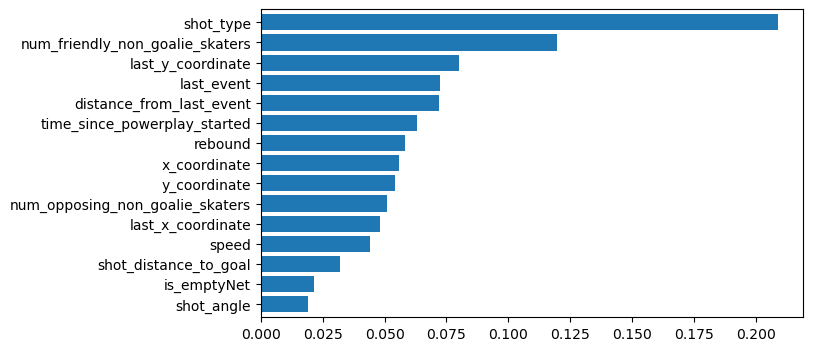

In [20]:
# Extract feature importance determined by RF model -- orig before extra 4 added
feature_imp = pd.Series(rf_best_pipe[-1].feature_importances_, index=X_train.columns[:15])
feature_imp.sort_values(ascending=True, inplace=True)

# Creating a bar plot
feature_imp.plot(kind='barh', width=0.8, figsize=(7,4))

{'web': 'https://www.comet.com/api/image/download?imageId=93f6bbe7748847ecb13c65307d7735ff&experimentKey=34144ddb714e4845be497ce0e144f098',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=93f6bbe7748847ecb13c65307d7735ff&experimentKey=34144ddb714e4845be497ce0e144f098',
 'imageId': '93f6bbe7748847ecb13c65307d7735ff'}

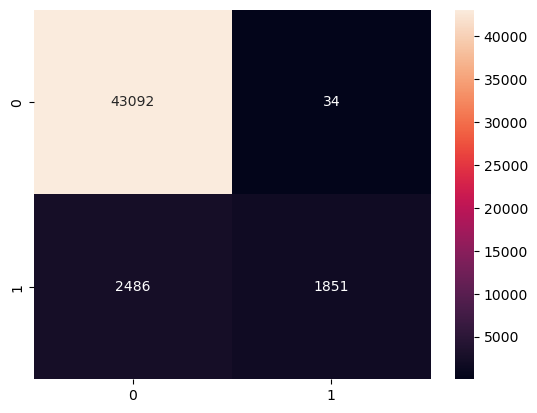

In [21]:
cm=confusion_matrix(y_test, rf_preds)
sns.heatmap(cm, annot=True,fmt="d")
experiment_rf.log_figure(figure_name='Confusion Matrix', step=None)

In [22]:
metrics = {"accuracy": accuracy_score(y_test, rf_preds), "f1": f1_score(y_test, rf_preds), "recall": recall_score(y_test, rf_preds), "precision": precision_score(y_test, rf_preds)}
parameter = {
    "model_type": 'Random Forest',
    "param_grid": str(rf_best_pipe.get_params()),
}
experiment_rf.log_parameters(parameter)
experiment_rf.log_metrics(metrics)

COMET WARNING: truncated string; too long: '{'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('Numerical_transform',
                                 Pipeline(steps=[('Impt', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x177094690>),
                                ('Categorical_transform',
                                 Pipeline(steps=[('Impt',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x177102190>)])), ('featu

### Prec-Recall Curve

{'web': 'https://www.comet.com/api/image/download?imageId=61c3900dbdb34fd3b66437ceb7b7dd27&experimentKey=34144ddb714e4845be497ce0e144f098',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=61c3900dbdb34fd3b66437ceb7b7dd27&experimentKey=34144ddb714e4845be497ce0e144f098',
 'imageId': '61c3900dbdb34fd3b66437ceb7b7dd27'}

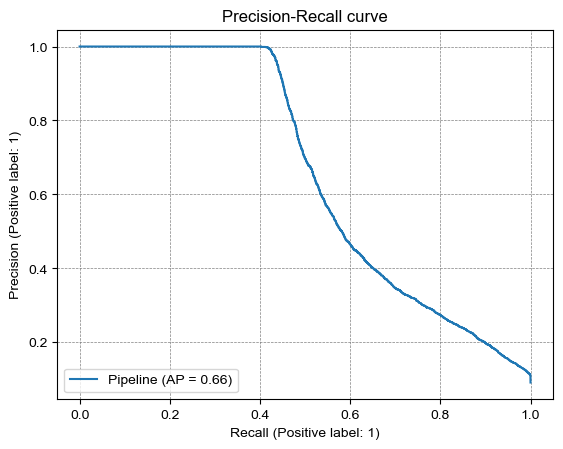

In [24]:
display = PrecisionRecallDisplay.from_estimator(rf_best_pipe, X_test, y_test)
sns.set()
display.ax_.set_title("Precision-Recall curve")
plt.grid(color='gray', linestyle='--', linewidth=0.5)
experiment_rf.log_figure(figure_name='Precision-Recall Curve', step=None)

### ROC Curve

In [25]:
def plot_roc_curve(y_test, preds_proba, model_name, curr_experiment):
    plt.figure(figsize=(10, 6))
    line_width = 2

    false_positive_rate, true_positive_rate, _ = roc_curve(y_test.ravel(),preds_proba[:,1].ravel())
    area_under_curve = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, lw=line_width, label=f"Model {model_name} - AUC: {area_under_curve:.2f}")

    plt.plot([0, 1], [0, 1], color="grey", lw=line_width, linestyle='--', label="Baseline (Random)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend(loc="lower right")
    curr_experiment.log_figure(figure_name='ROC-AUC', step=None)
    plt.show()

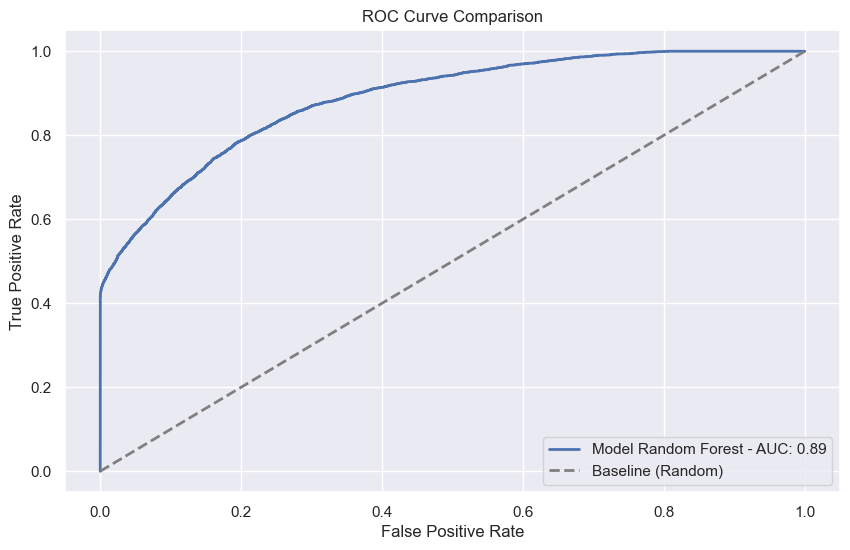

In [26]:
plot_roc_curve(y_test, rf_preds_prob, "Random Forest", experiment_rf)

### Goal Rate Plot

In [27]:
def generate_goal_rate_plot(model_name, binned_data, curr_experiment):
    plt.figure(figsize=(10, 5))
    plt.title("Analysis of Goal Rate by Model")
    sns.lineplot(x='goal_perc_bins', y='goal_rate', data=binned_data, linewidth=2.5, label=model_name)
    plt.xlabel('Model Probability Percentile')
    plt.ylabel('Goal Rate')
    plt.xticks(np.arange(0, 120, 20))
    plt.legend(loc="best")
    curr_experiment.log_figure(figure_name='Goal Rate Plot', step=None)
    plt.show()

In [28]:
bins = list(np.arange(0, 105,  5))
bin_centers = list(np.arange(2.5, 100,  5.0))
df_prob = pd.DataFrame(list(zip(rf_preds ,y_test ,rf_preds_prob[:,1]*100)), columns = ['goal_pred', 'goal','goal_probability'])
df_prob['shot'] = 1
sum_goal = df_prob['goal'].sum()
df_prob['percentile'] = df_prob['goal_probability'].rank(pct=True) * 100
df_prob['goal_perc_bins'] = pd.cut(df_prob['percentile'], bins, labels = bin_centers)
df_prob_bined = df_prob[['goal_perc_bins', 'shot', 'goal' ]].groupby(['goal_perc_bins']).sum().reset_index()
df_prob_bined['goal_rate'] = (df_prob_bined['goal']/df_prob_bined['shot'])
df_prob_bined['goal_cum'] = (df_prob_bined['goal']/sum_goal)
df_prob_bined['goal_cumsum'] = 1-df_prob_bined['goal_cum'].cumsum()

In [29]:
df_prob_bined

,goal_perc_bins,shot,goal,goal_rate,goal_cum,goal_cumsum
0,2.5,0,0,NaN,0.000000,1.000000
1,7.5,7582,0,0.000000,0.000000,1.000000
2,12.5,0,0,NaN,0.000000,1.000000
3,17.5,1910,9,0.004712,0.002075,0.997925
4,22.5,2373,27,0.011378,0.006226,0.991699
5,27.5,2373,31,0.013064,0.007148,0.984552
6,32.5,2374,52,0.021904,0.011990,0.972562
7,37.5,2373,53,0.022335,0.012220,0.960341
8,42.5,2373,59,0.024863,0.013604,0.946737
9,47.5,2373,64,0.026970,0.014757,0.931981


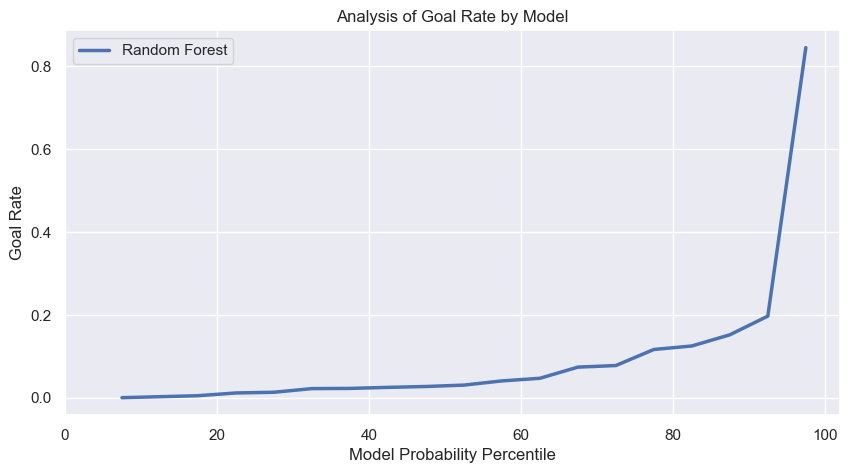

In [30]:
generate_goal_rate_plot("Random Forest", df_prob_bined, experiment_rf)

### Cumulative Goal Analysis

In [31]:
def visualize_cumulative_goals(model_name, binned_data, curr_experiment):
    plt.figure(figsize=(10, 5))
    plt.title("Cumulative Goals Analysis")
    sns.lineplot(x='goal_perc_bins', y='goal_cumsum', data=binned_data, linewidth=2.5, label=model_name)
    plt.xlabel('Percentile of Model Predictions')
    plt.ylabel('Cumulative Goal Ratio')
    plt.xticks(np.arange(0, 120, 20))
    plt.legend(loc="lower right")
    curr_experiment.log_figure(figure_name='Cumulative Goal Analysis Plot', step=None)
    plt.show()

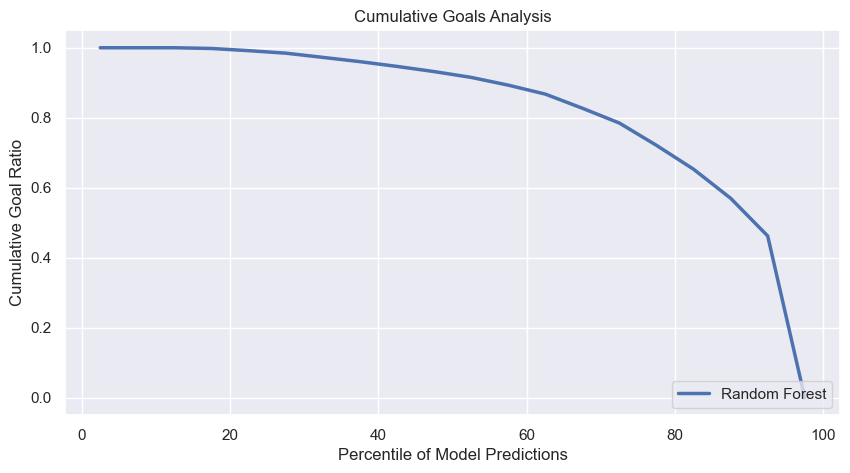

In [32]:
visualize_cumulative_goals("Random Forest", df_prob_bined, experiment_rf)

### Calibration curve

{'web': 'https://www.comet.com/api/image/download?imageId=ed4ab2c1c8214456b8c746ba03550727&experimentKey=34144ddb714e4845be497ce0e144f098',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=ed4ab2c1c8214456b8c746ba03550727&experimentKey=34144ddb714e4845be497ce0e144f098',
 'imageId': 'ed4ab2c1c8214456b8c746ba03550727'}

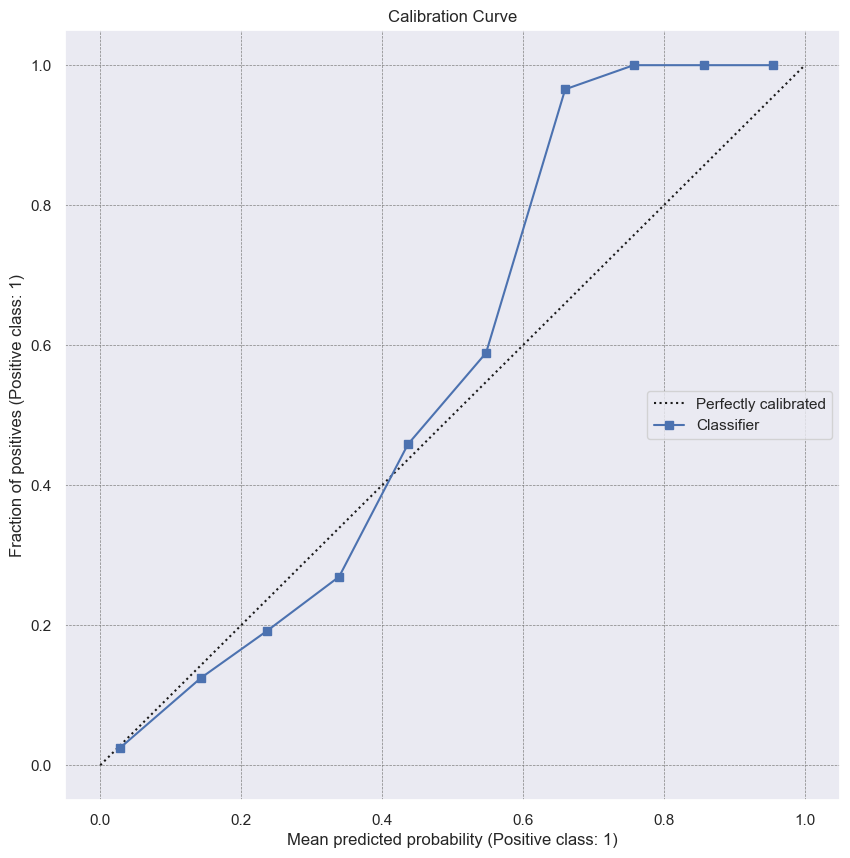

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
display = CalibrationDisplay.from_predictions(y_test, rf_preds_prob[:,1].ravel(), n_bins=10, ax=ax)
plt.grid(color='gray', linestyle='--', linewidth=.5)
plt.legend(loc="center right")
plt.title(f"Calibration Curve")
experiment_rf.log_figure(figure_name='Calibration Curve', step=None)

### Save Model

In [34]:
import pickle

In [37]:
if not os.path.exists('models/'):
    os.mkdir('models/')
    
pickle.dump(rf_best_pipe, open('models/Random_forest.sav', 'wb'))
experiment_rf.log_model("Random Forest Clf", 'models/Random_forest.sav')

{'web': 'https://www.comet.com/api/asset/download?assetId=2a7050c0e16d4361bb1634117dce5d63&experimentKey=34144ddb714e4845be497ce0e144f098',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=2a7050c0e16d4361bb1634117dce5d63&experimentKey=34144ddb714e4845be497ce0e144f098',
 'assetId': '2a7050c0e16d4361bb1634117dce5d63'}

In [38]:
experiment_rf.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/mahmoodhegazy/nhl-data-science/34144ddb714e4845be497ce0e144f098
COMET INFO:   Metrics:
COMET INFO:     accuracy  : 0.9469060109980406
COMET INFO:     f1        : 0.5949855351976856
COMET INFO:     precision : 0.9819628647214854
COMET INFO:     recall    : 0.42679271385750517
COMET INFO:   Parameters:
COMET INFO:     model_type : Random Forest
COMET INFO:     param_grid : {'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('Numerical_transform',
                                 Pipeline(steps=[('Impt', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
     